In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# File paths
file_paths = {
    2021: "../dataset/chennai-ground-water-levels-2021.csv",
    2022: "../dataset/chennai-ground-water-levels-2022.csv",
    2023: "../dataset/chennai-ground-water-levels-2023.csv",
    2024: "../dataset/chennai-ground-water-levels-2024.csv",
}

# Standardized Monthly Column Names
monthly_columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Load and prepare data
def load_and_prepare_data(year, file_path):
    df = pd.read_csv(file_path)

    # **Fix column names (Remove trailing spaces)**
    df.columns = df.columns.str.strip()

    # **Ensure all required columns exist**
    missing_cols = set(monthly_columns) - set(df.columns)
    for col in missing_cols:
        df[col] = np.nan  # Fill missing months with NaN

    # Convert monthly values to numeric
    df[monthly_columns] = df[monthly_columns].apply(pd.to_numeric, errors='coerce')

    # Handle missing months for 2024 (Apr-Dec)
    if year == 2024:
        df.loc[:, monthly_columns[3:]] = np.nan  

    # Compute yearly average
    df["Yearly Average"] = df[monthly_columns].mean(axis=1)
    df["Year"] = year  # Add Year column

    print(f"✅ {year} processed successfully. (Missing cols added: {missing_cols})")
    
    return df

# Load datasets
df_list = []
for year, path in file_paths.items():
    df_list.append(load_and_prepare_data(year, path))

# Combine all data
df_all_years = pd.concat(df_list, ignore_index=True)

# Save cleaned data to CSV
output_csv_path = "./output/temporal_analysis_data.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
df_all_years.to_csv(output_csv_path, index=False)
print(f"📄 Processed data saved to: {output_csv_path}")

# Ensure "Area No." is present
if "Area No." not in df_all_years.columns:
    raise ValueError("❌ Dataset missing 'Area No.' column.")

# Group by Area No.
area_groups = df_all_years.groupby("Area No.")["Yearly Average"].mean()

# Save Area-wise data
area_avg_csv = "./output/area_wise_groundwater_levels.csv"
area_groups.to_csv(area_avg_csv, header=True)
print(f"📊 Area-wise analysis saved to: {area_avg_csv}")

# **Plot Generation**
output_dir = "Temp_Analysis_GWater"
os.makedirs(output_dir, exist_ok=True)

# Get unique locations and split into groups of 6
locations = df_all_years["Location"].unique()
num_plots = int(np.ceil(len(locations) / 6))

years = [2021, 2022, 2023, 2024]
for year in years:
    df_year = df_all_years[df_all_years["Year"] == year]

    for i in range(num_plots):
        plt.figure(figsize=(12, 6))
        start_idx, end_idx = i * 6, (i + 1) * 6

        for location in locations[start_idx:end_idx]:
            subset = df_year[df_year["Location"] == location]
            if not subset.empty:
                plt.plot(monthly_columns, subset[monthly_columns].iloc[0].values, marker='o', label=location)

        plt.xlabel("Months")
        plt.ylabel("Groundwater Level (m)")
        plt.title(f"Groundwater Levels - {year} (Wards {start_idx + 1}-{min(end_idx, len(locations))})")
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        plt.grid()
        plt.tight_layout()

        # Save plot
        plt.savefig(os.path.join(output_dir, f"Groundwater_Levels_{year}_Plot_{i+1}.png"))
        plt.close()

# **Final Summary**
print("\n📊 Average Yearly Groundwater Levels by Area No.:")
print(area_groups)


✅ 2021 processed successfully. (Missing cols added: set())
✅ 2022 processed successfully. (Missing cols added: set())
✅ 2023 processed successfully. (Missing cols added: set())
✅ 2024 processed successfully. (Missing cols added: {'Jun', 'Apr', 'Nov', 'Oct', 'May', 'Sep', 'Aug', 'Dec', 'Jul'})
📄 Processed data saved to: ./output/temporal_analysis_data.csv
📊 Area-wise analysis saved to: ./output/area_wise_groundwater_levels.csv

📊 Average Yearly Groundwater Levels by Area No.:
Area No.
I       3.469815
III     6.758865
IV      4.177886
IX      6.457327
V       6.370485
VI      7.747850
VII     5.530547
VIII    4.651846
X       5.300964
XI      3.159857
XII     4.118907
XIII    2.502468
XIV     3.696203
XV      3.498714
Name: Yearly Average, dtype: float64


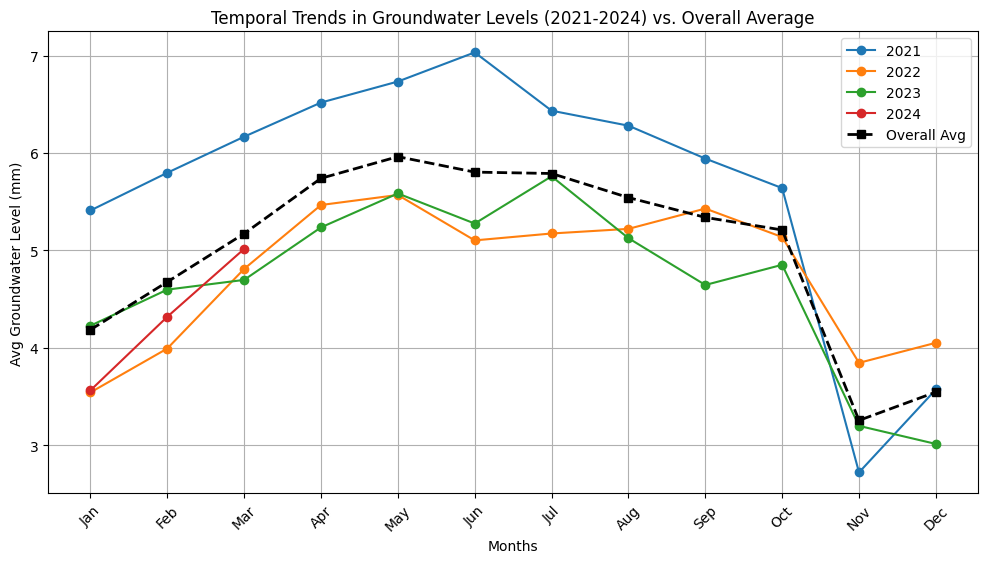

📊 Temporal trends visualization saved to: ./output/Temporal_Trends_Groundwater.png


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load processed data
df_all_years = pd.read_csv("./output/temporal_analysis_data.csv")

# Standardized Monthly Column Names
monthly_columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Group data by Year and compute mean groundwater levels per month
monthly_trends = df_all_years.groupby("Year")[monthly_columns].mean()

# Compute overall average trend across all years
overall_avg = monthly_trends.mean(axis=0)

# **Plot the Temporal Trends**
plt.figure(figsize=(12, 6))

# Plot yearly trends
for year in monthly_trends.index:
    plt.plot(monthly_columns, monthly_trends.loc[year], marker='o', linestyle='-', label=f"{year}")

# Plot overall average trend
plt.plot(monthly_columns, overall_avg, marker='s', linestyle='--', color='black', linewidth=2, label="Overall Avg")

# Formatting
plt.xlabel("Months")
plt.ylabel("Avg Groundwater Level (mm)")
plt.title("Temporal Trends in Groundwater Levels (2021-2024) vs. Overall Average")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Save the plot
output_plot = "./output/Temporal_Trends_Groundwater.png"
plt.savefig(output_plot, bbox_inches="tight")
plt.show()

print(f"📊 Temporal trends visualization saved to: {output_plot}")
